
<h1 style="font-family:times new roman;"> <center>Grocery Market Basket Analysis</center> </h1>

<p><center style="color:#159364; font-family:times new roman; font-size:16px">Market basket analysis using Apriori algothrithm performed on grocery transactions dataset.</center></p>

***

<h2 style='font-family:times new roman'>Introduction</h2>

<p style='font-size:16px; font-family:times new roman'>It is no secret that retailers extract information from consumer data that can help them create effective marketing tactics. Market basket analysis is one application of association analysis, a technique used to find patterns in items within a large dataset[1]. In the Power of Habit, Charles Duhigg shares an anecdote about Target executives who were trying to identify which of their customers were pregnant. For retailers, like Target, this piece of information would allow them to identify customers who made frequent purchases like diapers or groceries or school supplies. 
Market basket analysis is a tool that can help determine if there is a connection between items purchased together. Using a dataset full of transactional data from grocery stores, an exploratory analysis will be conducted to find any interesting trends. Additionally, the Apriori algorithm will be applied to the dataset to find the frequent itemset and using market basket analysis determine if an interesting association exists between items.</p>

<h2 style='font-family:times new roman'>Data</h2>

<p style='font-size:16px;font-family:times new roman'>The dataset in this analysis is publicly available through Kaggle [2]. The dataset contains 38,765 rows of billing data collected from grocery stores from January 2014 to December 2015. The dataset includes the ID of the members, date of purchase and a description of the items. It should be noted that the data is limited in that it only contains two years’ worth of data and no additional information on the grocery store(s) is provided.</p>

<h2 style='font-family:times new roman'> Setting up enviroment in Python </h2>

In [ ]:
# # Importing necessary packages
import pandas as pd
from matplotlib import pyplot as plt
!pip install apyori
from apyori import apriori

<p style='font-size:16px;font-family:times new roman'>Importing dataset, creating a Pandas dataframe.</p>

In [ ]:
df = pd.read_csv('../input/groceries-dataset/Groceries_dataset.csv')

<h2 style='font-family:times new roman'>Cleaning Data</h2>

<p style='font-size:16px;font-family:times new roman'>Preview dataset.</p>

In [ ]:
df.head(3)

<p style='font-size:16px;font-family:times new roman'>Check for null values.</p>

In [ ]:
df.isnull().sum()

<p style='font-size:16px;font-family:times new roman'>Change column names.</p>

In [ ]:
df.columns = ['member_id','date','items']

<p style='font-size:16px;font-family:times new roman'>Change datatypes in dataframe.</p>

In [ ]:
df.info()
df['date']= pd.to_datetime(df['date'])

<h2 style='font-family:times new roman'>Analysis</h2>

<p style='font-size:16px;font-family:times new roman'>Before doing the market basket analysis, it will be useful to conduct a simple, exploratory analysis of the dataset. This may help identify interesting or relevant information regarding the data.</p>

<p style='font-size:16px;font-family:times new roman'>To start off, the dataset is filtered and sorted to find the top items purchased by customers from January 2014 to December 2015. The data shows that milk, vegetables, and bread are the most frequently purchased items.</p>

In [ ]:
# # Top purchased items. 
item_count=df[['member_id','items']].groupby('items',as_index=False)['member_id'].count(
    ).sort_values(by='member_id',ascending=False)
item_count.rename(columns = {'member_id':'count'},inplace=True)
item_count.head()

In [ ]:
# # Graph.
my_color_pal = [
    'MediumSeaGreen',
    'LightSeaGreen',
    'MediumAquaMarine',
    'LightSkyBlue',
    'LightSteelblue',
    'PowderBlue',
    'Plum',
    'LightSalmon',
    'LightPink',
    'Moccasin',
    ]

y_axis = item_count['items'].head(10)
x_axis = item_count['count'].head(10)

plt.barh(y_axis,x_axis, color = my_color_pal,edgecolor='Silver')

plt.title('Top Ten Purchased Items: Jan 2014 - Dec 2015', color='steelblue',
fontfamily='times new roman',fontsize=18)
plt.xlabel('Purchase Frequency')

plt.show()


<p style ='font-size:16px;font-family:times new roman'>There are 3,898 different members in the dataset and on average they purchased 10 items per trip. </p>

In [ ]:
# # Average purchase count.
member_items = df.groupby('member_id', as_index=False)['items'].count()
print('On average, members purchased: {x} items.'.format(
    x= round((member_items['items'].mean()),1)))

<p style='font-size:16px;font-family:times new roman'>It would be interesting to identify if it there was a disproportional number of purchases made on a certain day of the week. Do grocery stores have more members making purchases on a certain day of the week? </p>

In [ ]:
weekday_df = df[['member_id', 'date']]

weekday_df = weekday_df.groupby('date', as_index=False)['member_id'].nunique()

weekday_df['weekday'] = weekday_df['date'].dt.day_name()

weekday_df = weekday_df.groupby('weekday', as_index=False)['member_id'].mean().sort_values(
    by='member_id', ascending=False)
weekday_df.rename(columns={'member_id': 'average_members'}, inplace=True)

<p style='font-size:16px;font-family:times new roman'>The groceries in the dataset can expect anywhere from 19 to 21 transaction made my members across the week. However, it is evident that there is not a significant difference in the number of transactions made by the members from Thursday to Monday.</p>

In [ ]:
# # Graph
x = weekday_df['weekday']
y = weekday_df['average_members']
plt.bar(x, y, color='MediumSeaGreen', edgecolor='black')
plt.xticks(rotation=20)
plt.title('Average Number of Member Transcations', color='steelblue',
          fontfamily='times new roman', fontsize=18)
plt.show()

<p style='font-size:16px;font-family:times new roman'>In order to apply the Apriori algorithm, a new dataframe is created that contains a list of items each member purchased on each day.</p>

In [ ]:
basket_df = df.groupby(['member_id', 'date'], as_index=True)['items'].apply(lambda x: list(x))

transactions = basket_df.values.tolist()

transactions[:10]

<p style='font-size:16px;font-family:times new roman'>Since there are many association rules that are possible the Apriori algorithm is used to placed constraints so that the most interesting rules are selected [3].</p>

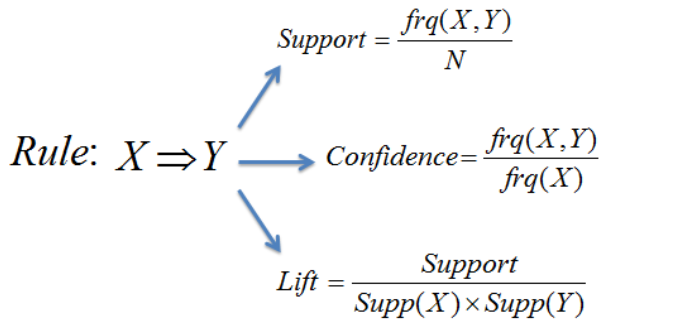

<p style='font-size:16px;font-family:times new roman'>Support represents the popularity of an item in the itemset. Setting the support to a minimum value creates a threshold that identifies significant item pairs. Confidence signifies the likelihood of item Y being purchased when item X is purchased. The confidence value can be misleading if both items are popular. It could be that X and Y appear together frequently because of their individual popularity and not necessarily an association between them. Lift considers the popularity of item Y when determining the likelihood of it being purchased in the same transaction as item X. A lift value greater than one can be indicative of a pattern between the items.</p>

In [ ]:
# # Using the apriori function to create the association rules.
association_rules = apriori(transactions,
                            min_support=0.0003,
                            min_lift=2,
                            min_confidence=0.05,
                            min_length=2)
association_results = list(association_rules)
# # Using the association rules yiels 104 rules that meet the qualifications.
print(len(association_results))

In [ ]:
results = []
for item in association_results:
    itemset = item[0]
    items = [x for x in itemset]

    value0 = str(items[0])
    value1 = str(items[1])
    value3 = str(item[1])[:7]
    value4 = str(item[2][0][2])[:7]
    value5 = str(item[2][0][3])[:7]

    rows = (value0, value1, value3, value4, value5)
    results.append(rows)
    columns = ['item_x', 'item_y', 'support', 'confidence', 'lift']

    associations_df = pd.DataFrame(results, columns=columns)
    associations_df.head(5)

<p style='font-size:16px;font-family:times new roman'>The results of applying Apriori to the dataset indicate that the items whole milk, and sausage have the highest support values and the lift is approximately 2.18. It can be assumed that yogurt and sausage are common breakfast items in the US and that is why they are purchased together frequently. </p>

In [ ]:
associations_df=associations_df.sort_values(by=['support', 'lift'],
                            ascending=[False, False]).head(100)
associations_df.head(20)

In [ ]:
# # Max support value.
associations_df.sort_values(by='support',ascending=False).head(1)

<p style='font-size:16px;font-family:times new roman'>The itemset of fruit/vegetable juice and sausage have the highest lift value of 8.29 and a relatively high confidence value of 50%. However, the support value is low suggesting that they are not purchased as frequently as other items in the dataset.</p>

In [ ]:
# # Max lift value. 
associations_df.sort_values(by='lift',ascending=False).head(1)

<h2 style='font-family:times new roman'>Recommendation<h2>

<p style='font-size:16px;font-family:times new roman'>Data that contains information about consumer’s purchasing habits is very valuable to retailers because by applying useful analysis tools like association rules, important trends and patterns can be uncovered. The exploratory analysis of the data revealed that the top purchased items were milk, vegetables, and bread. Members, on average, purchased ten items. It can be assumed that at least one of the top products will appear in the average member’s grocery cart. If they are potentially only purchasing ten items, it will benefit the grocery stores to prioritize their top sellers. Market basket analysis can provide businesses with a clearer picture of what their customers are more likely to purchase. The grocery stores in this dataset can use the association rules created in this analysis to advertise certain items their members with discounts that will encourage them to purchase more. Finding the right connection between two items can be the difference between a member purchasing that eleventh or twelfth item.</p>

<h2 style='font-family:times new roman'>Tableau Dashboard <h2>

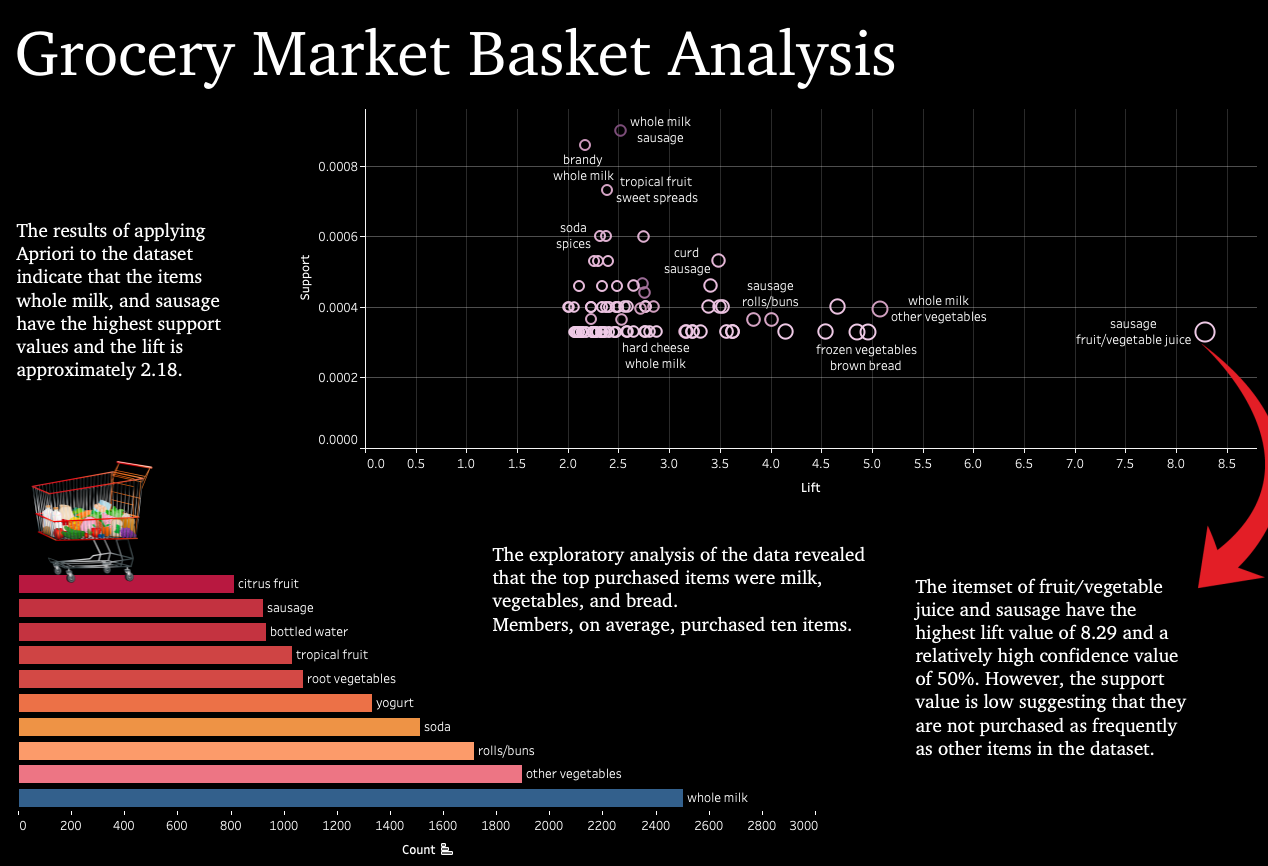

<h2 style='font-family:times new roman'>References </h2>

1. [Moffit, Chris. (2017 July 3).Introduction to Market Basket Analysis in Python.](https://pbpython.com/market-basket-analysis.html)
2. [Dedhia, Heeral.(2020 Sep 17).Kaggle.](https://www.kaggle.com/heeraldedhia/groceries-dataset)
3. [Jain Rashmi.(2017 March 24). A Beginner’s Tutorial on Apriori Algorithm in Data Mining with R Implementation.Hackerearth.](https://www.hackerearth.com/blog/developers/beginners-tutorial-apriori-algorithm-data-mining-r-implementation/.)
***
The following Kaggle notebooks used the same dataset and where very helpful in helping me understand the concepts of association rule learning and market basket analysis:
1. [Heeral Dedhia's Market Basket Analsyis Using Apriori Algorithm](https://www.kaggle.com/heeraldedhia/market-basket-analysis-using-apriori-algorithm/)
2. [Anubha Singh's Groceries Association Rule Apriori Algorithm](https://www.kaggle.com/cerolacia/groceries-asscociation-rule-apriori-algorithm)
3. [Gaurav Chopra's Introduction to Association Rule Mining](https://www.kaggle.com/gauravchopracg/introduction-to-association-rule-mining)  
***
The following youtube videos helped me understand the concepts. 
1. [Market Basket Analysis with Excel](https://youtu.be/aslTl6i-hpQ)
2. [Apriori Algorithm Explained](https://youtu.be/guVvtZ7ZClw)
3. [Implementing Apriori algorithm in Python](https://youtu.be/SVM_pX0oTU8)